# Bagging (Bootstrap Aggregating)
## Autor: Mariano F.M.A.S.
### Data: 10/09/2023


Neste notebook, exploramos como otimizar e melhorar o treinamento de um modelo de Rede Neural Convolucional (CNN) usando PyTorch. Reaproveitamos parte das função construidas em `3-mnist-CNN-cross-validation-LrScheduler`.

# Objetivos:

- Melhorar os resultados obtidos em `3-mnist-CNN-cross-validation-LrScheduler` usando o Método dos Ensembles (Bagging). 
- Acelerar o treinamento diminuindo o parâmetro `lr` sem usar o LrScheduler.
- Usar uma nova arquitetura de CNN. 
 
# Método dos Ensembles
O método dos ensembles é uma técnica que visa melhorar o desempenho e a generalização de modelos combinando várias previsões de diferentes modelos. Em vez de confiar apenas em um único modelo, os ensembles combinam as previsões de vários modelos para obter um resultado final mais robusto e preciso.

Existem várias abordagens para criar ensembles, sendo as mais populares:

1. **Bagging (Bootstrap Aggregating)**: Nessa técnica, múltiplos modelos (geralmente do mesmo tipo) são treinados em diferentes subconjuntos aleatórios do conjunto de treinamento, permitindo que cada modelo veja uma parte diferente dos dados. As previsões de cada modelo são combinadas por votação (para problemas de classificação) ou média (para problemas de regressão) para obter o resultado final.

2. **Boosting**: O boosting é outra abordagem de ensemble em que os modelos são treinados de forma sequencial, onde cada modelo subsequente se concentra nos erros cometidos pelos modelos anteriores. O objetivo é melhorar o desempenho geral, dando mais peso aos exemplos mal classificados. Alguns algoritmos de boosting populares são AdaBoost e Gradient Boosting Machines (GBM).

3. **Stacking**: O stacking envolve o treinamento de múltiplos modelos de aprendizado de máquina, cujas previsões são usadas como entrada para um novo modelo chamado meta-modelo. O meta-modelo é treinado para fazer a previsão final com base nas previsões dos modelos base, permitindo que os modelos se complementem e capturem diferentes aspectos dos dados.

4. **Random Forests**: Uma técnica específica de ensemble que usa bagging com árvores de decisão. As árvores de decisão são combinadas para fazer uma previsão final, e a aleatoriedade na construção das árvores ajuda a reduzir o overfitting e aumentar a robustez.

Os ensembles são úteis porque, ao combinar várias previsões de modelos diferentes, eles tendem a reduzir o viés, a variância e a ocorrência de overfitting, resultando em modelos mais gerais e com melhor desempenho em dados não vistos.  

In [2]:
import os
import math
import torch
import random
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, TensorDataset, Subset
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, matthews_corrcoef, cohen_kappa_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc  
 
from PIL import Image
from torch.utils.data import Subset
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
 
# Checking GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training on device: ", device)
  
!pip install torchsummary
from torchsummary import summary

  

Training on device:  cuda:0


# Carregando os dados

## Criando os Dataset 

Em termos de imagens, isso geralmente é usado para formatar uma imagem plana 1D em uma imagem 2D. No conjunto de dados MNIST cada imagem é de 28x28 pixels, mas as imagens são armazenadas como arrays 1D de 784 elementos. Então, `.reshape((1, 28, 28))` está reformatando essa imagem 1D em uma imagem 2D de 28x28 pixels. A dimensão extra (1) é usada para indicar o número de canais de cor na imagem. Neste caso, é 1 porque as imagens MNIST são em escala de cinza e, portanto, têm apenas um canal de cor.

### Transforms - RandomAffine 

**Função `transforms.RandomAffine`:**
A função `transforms.RandomAffine` é uma transformação de data augmentation (aumento de dados) disponível na biblioteca `transforms` do torchvision, que é amplamente utilizada em tarefas de visão computacional. Essa transformação aplica uma combinação de translações, rotações, escalas e cisalhamentos aleatórios nas imagens durante o treinamento do modelo. Isso é útil para aumentar a variedade dos dados de treinamento e melhorar a capacidade de generalização do modelo.

**Parâmetros:**
A função `transforms.RandomAffine` aceita vários parâmetros que controlam a quantidade e o tipo de transformações aleatórias aplicadas nas imagens. Os principais parâmetros são os seguintes:

1. `degrees`: Define o intervalo de rotação aleatória em graus. Por exemplo, `degrees=(-15, 15)` fará com que a imagem seja rotacionada aleatoriamente entre -15 e 15 graus.

2. `translate`: Define o intervalo de translação aleatória em pixels. Por exemplo, `translate=(0.1, 0.1)` permitirá uma translação aleatória de até 10% da altura e largura da imagem.

3. `scale`: Define o intervalo de escalas aleatórias. Por exemplo, `scale=(0.8, 1.2)` fará com que a imagem seja escalada aleatoriamente entre 80% e 120% do tamanho original.

4. `shear`: Define o intervalo de cisalhamento aleatório em graus. Por exemplo, `shear=(-10, 10)` fará com que a imagem seja inclinada aleatoriamente entre -10 e 10 graus.

**Funcionamento:**
Quando aplicada a uma imagem, a função `transforms.RandomAffine` seleciona aleatoriamente os parâmetros de rotação, translação, escala e cisalhamento de acordo com os intervalos especificados nos parâmetros. Em seguida, ela aplica essas transformações à imagem, gerando uma nova imagem aumentada. O modelo é então treinado usando essa nova imagem, juntamente com as outras transformações e os dados originais.
  
#### interpolation

O parâmetro `interpolation` em `transforms.RandomAffine` e outras transformações de imagem no PyTorch define o método de interpolação a ser usado durante as transformações geométricas. A interpolação é um processo utilizado para estimar os valores de pixels em uma imagem após uma transformação que resulta em posições de pixel não inteiras.

Quando aplicamos transformações como rotação, translação, escala ou cisalhamento em uma imagem, os pixels originais podem se mover para posições não inteiras na imagem transformada. Para determinar os valores de pixel nessas novas posições, é necessário realizar um cálculo de interpolação, que é uma estimativa baseada nos valores dos pixels vizinhos na imagem original.

O parâmetro `interpolation` pode receber um dos seguintes valores:

- `False` (padrão): Isso significa que a interpolação bilinear será usada. A interpolação bilinear estima os valores dos pixels na imagem transformada através de uma média ponderada dos quatro pixels vizinhos mais próximos. É um método de interpolação suave e é adequado para a maioria das transformações geométricas.

- `Image.NEAREST`: Isso indica o método de interpolação de vizinho mais próximo, também conhecido como interpolação por pixel mais próximo. Nesse método, o valor do pixel mais próximo na imagem original é atribuído ao novo pixel na imagem transformada. Essa interpolação é rápida e útil quando você deseja preservar características distintas e nítidas nas imagens, mas pode levar a resultados menos suaves em algumas transformações.

- `Image.BOX`: Isso usa a interpolação da média de caixa (box averaging), que é similar à interpolação bilinear, mas considera uma área maior de pixels vizinhos. Ela é ligeiramente mais rápida do que a interpolação bilinear, mas pode resultar em resultados menos suaves.

- `Image.BILINEAR`: Este é o mesmo que usar `False`, ou seja, a interpolação bilinear será usada.

- `Image.HAMMING`: Usa a interpolação de janela de Hamming, que é uma variação da interpolação bilinear. Pode ser mais suave que a interpolação bilinear, mas é mais lenta.

- `Image.BICUBIC`: Usa a interpolação bicúbica, que leva em consideração 16 pixels vizinhos para estimar o novo valor do pixel. É uma interpolação mais precisa, mas mais lenta que a bilinear.

Cada método de interpolação tem suas próprias características e é mais adequado para diferentes tipos de transformações e efeitos desejados. Em geral, a interpolação bilinear é amplamente usada e fornece resultados satisfatórios na maioria dos casos. Se você tiver necessidades específicas ou quiser obter resultados mais nítidos ou suaves, pode experimentar diferentes métodos de interpolação.

Para imagens em preto e branco (ou monocromáticas), geralmente o método de interpolação mais adequado é o `Image.NEAREST`, também conhecido como interpolação por vizinho mais próximo.

O método `Image.NEAREST` atribui a cada novo pixel na imagem transformada o valor do pixel mais próximo na imagem original. Isso significa que a interpolação preservará as características distintas da imagem original e produzirá resultados nítidos e sem suavização. Como as imagens em preto e branco geralmente têm contornos claros e definidos, esse método de interpolação é adequado para preservar essas características importantes.

A interpolação bilinear (usada por padrão quando `interpolation=False` ou `Image.BILINEAR`) leva em consideração uma área maior de pixels vizinhos para estimar os novos valores de pixel. Isso pode suavizar as bordas e detalhes nas imagens em preto e branco, o que pode não ser desejado, especialmente se você deseja manter a nitidez das características distintas.

Portanto, se você está trabalhando com imagens em preto e branco e deseja preservar a nitidez das características, é recomendado usar `interpolation=Image.NEAREST` ao aplicar transformações geométricas como rotação, translação, escala ou cisalhamento. Isso garantirá que as transformações sejam aplicadas sem suavização e que a aparência geral da imagem preto e branco seja preservada.

In [3]:
#Carregando os dados 

# Dados de treinamento  
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
# Dados para validação do modelo
test_data  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# Definindo a classe do dataset de Test
class MNISTDataset_test(Dataset):
    def __init__(self, test_data):
        self.test_data = test_data
    
    def __len__(self):
        return len(self.test_data)
    
    def __getitem__(self, index): 
        image = torch.tensor(self.test_data.iloc[index, :].values.astype(float).reshape((1, 28, 28))/255.0, dtype=torch.float32) 
        return image

# Criando o dataloader de test
test_dataset = MNISTDataset_test(test_data)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


In [ ]:


# Definindo a classe do dataset de Treino
class MNISTDataset(Dataset): 
    def __init__(self, data, transform=None, add_noise=False, noise_mean=0, noise_std=0.1):
        """
        Inicialização da classe MNISTDataset.

        Parâmetros:
        - data: DataFrame contendo os dados do conjunto de dados MNIST.
        - transform: Objeto de transformação para aplicar nas imagens (opcional).
        - add_noise: Booleano que indica se deseja adicionar ruído gaussiano às imagens (opcional).
        - noise_mean: Média do ruído gaussiano (padrão é 0, opcional).
        - noise_std: Desvio padrão do ruído gaussiano (padrão é 0.1, opcional).
        """
        self.data = data
        self.transform = transform
        self.add_noise = add_noise
        self.noise_mean = noise_mean
        self.noise_std = noise_std

    def __len__(self):
        """
        Retorna o tamanho do dataset, ou seja, o número de amostras.
        """
        return len(self.data)

    def __getitem__(self, index):
        """
        Retorna uma amostra do dataset no índice especificado.

        Parâmetros:
        - index: O índice da amostra a ser retornada.

        Retorna:
        - image: A imagem da amostra como um tensor PyTorch.
        - label: O rótulo da amostra como um tensor PyTorch (classe da imagem).
        """
        # Converte os valores dos pixels da imagem em um tensor PyTorch normalizado no intervalo [0, 1]
        image = torch.tensor(self.data.iloc[index, 1:].values.astype(float).reshape((1, 28, 28)) / 255.0, dtype=torch.float32)

        # Obtém o rótulo da imagem como um tensor PyTorch
        label = torch.tensor(self.data.iloc[index, 0], dtype=torch.long)

        if self.add_noise:
            # Adiciona ruído gaussiano à imagem usando a biblioteca NumPy
            noise = np.random.normal(self.noise_mean, self.noise_std, size=image.shape)
            image = image + torch.tensor(noise, dtype=torch.float32)

        if self.transform is not None:
            # Aplica a transformação especificada (se houver) na imagem
            image = self.transform(image)

        return image, label

    

# Define a transformação RandomAffine com rotação de -30 a 30 graus, translação de -20% a 20% do tamanho da imagem,
# escala de 0.7 a 1.3 e um cisalhamento com um ângulo de -10 a 10 graus no sentido horizontal

transform_affine = transforms.RandomAffine(degrees=30, 
                                           translate=(0.2, 0.2), 
                                           scale=(0.7, 1.2), 
                                           shear=(-10, 10), 
                                           interpolation=Image.NEAREST)
    
     

In [4]:
#train_dataset Sem transform e sem Noise
train_dataset_original = MNISTDataset(train,transform=None, add_noise=False, noise_mean=None, noise_std=None) 

# NOISE
train_dataset_noise = MNISTDataset(train,transform=None, add_noise=True, noise_mean=0, noise_std=0.009)

#transform_affine
train_dataset_affine = MNISTDataset(train,transform=transform_affine, add_noise=False, noise_mean=None, noise_std=None)

 
# Junta todos os Dataset
dataset_concat_train= ConcatDataset([train_dataset_original,train_dataset_noise, train_dataset_affine])


In [5]:
# train_validation_splitdataset
def train_validation_splitdataset(dataset, validation_ratio=0.2,batch_size=500 ):
    # Calcule o tamanho do conjunto de validação
    num_validation_samples = int(validation_ratio * len(dataset))

    # Calcule o tamanho do conjunto de treinamento
    num_train_samples = len(dataset) - num_validation_samples

    # Use torch.utils.data.random_split para dividir o conjunto de dados
    train_dataset, validation_dataset = random_split(dataset, [num_train_samples, num_validation_samples])

    return train_dataset, validation_dataset 

 


## Visualizando os Dados de Treinamento

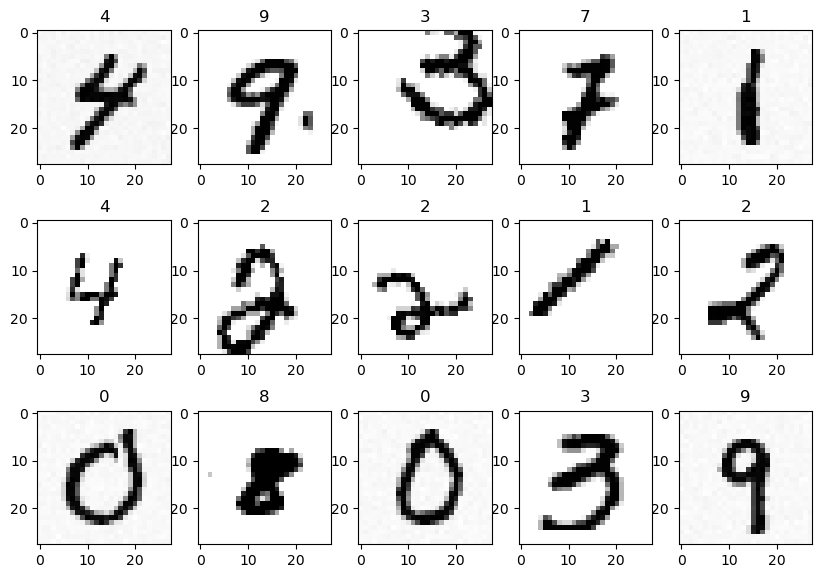

In [6]:
#train_dataset_original
train_loader_CNN = DataLoader(dataset_concat_train, batch_size=64, shuffle=True )
 
 
fig, axis = plt.subplots(3, 5, figsize=(10, 7))

for images, labels in train_loader_CNN:
    for i, ax in enumerate(axis.flat):
        image, label = images[i], labels[i]
        
        ax.imshow(image.view(28, 28), cmap='binary') # add imagem
        ax.set(title = f"{label}") # add label
    break  


# Função de Treinamento

A função`train_acel()` faz o treinamento de UM modelo reduzindo a taxa de aprendizagem lr até um minimo.

Onde:

- lr_ini: Valor inicial de lr

- patience_lr: Número de epocas sem a accuracy melhorar

- min_lr: Valor minimo de lr.

- factor_lr: Fator que será multiplicado por lr até chegar ao `min_lr`


- model: Modelo que será Treinado

- name: Nome usado para salvar os melhores modelos.

- train_loader e val_loader: DataLoader de treinamento e validação

- batches_verbose: True ou False para exibir o progresso do trenamento durante cada epoca 

- criterion: Função de perda

- optimizer: optimizer

- patience: Número de epocas sem a accuracy melhorar necessário para  interromper o treinamento 


In [ ]:


 def train_acel(model,name,train_loader, val_loader, batches_verbose, criterion, optimizer,
                     patience, patience_lr, min_lr, factor_lr, lr_ini ):
    best_accuracy = 0.0
    model.train()
    epoch = 0
    min_lr_temp=lr_ini
    epochs_without_improvement = 0
 
    losses_batch=[]
    acc=[]

    #############
    total_batches = len(train_loader)
    batches_processed = 0
    progress_threshold = total_batches // 10  # 20% do total de batches
    #############
    while True:
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses_batch.append(loss.item())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ############
            batches_processed += 1
            # Verifica se chegou ao limite para imprimir o número do batch
            if (batches_verbose ) and (batches_processed % progress_threshold == 0):
                print(f" Epoch [{epoch+1}], Batch [{batch_idx+1}/{total_batches}],  Loss: {round(loss.item(), 5)},")
            ############
        # Validação
        accuracy, validation_loss, loss_val = validate(model, val_loader, criterion)
        acc.append(accuracy)
        print(f" Epoch [{epoch+1}], Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.3f}%")
        epoch += 1
        # Verifica se a acurácia melhorou
        if  accuracy  >  best_accuracy  :
            best_accuracy = accuracy
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_model_{name}_train.pth')  # Salva o modelo com a melhor acurácia para o fold atual
        else:
            epochs_without_improvement += 1 
        ########################################
        # Se o valor de accuracy não aumentar após um número 'patience_lr' de épocas, o valor da taxa de aprendizado ´lr´ será reduzido
        if (epochs_without_improvement == patience_lr   ): 
            if (min_lr<round(min_lr_temp, int(-math.log10(min_lr_temp))) ):
                print('epochs_without_improvement: ',epochs_without_improvement)
                epochs_without_improvement = 0
                for param_group in optimizer.param_groups:
                    new_lr = param_group['lr'] * factor_lr
                    new_lr = max(new_lr, min_lr)
                    param_group['lr'] = new_lr
                    min_lr_temp = new_lr
                print('lr Atualizado: ', min_lr_temp) 
        if (epochs_without_improvement == patience):
            print('No improvement.')
            break     
    print('Stopping training!')
    return losses_batch,acc


def validate(model, val_loader, criterion):
    model.eval()  # Defina o modelo para o modo de avaliação
    correct = 0
    total = 0
    validation_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)   #Encontra o índice da probabilidade máxima
            # A função torch.max() retorna dois valores: o primeiro é o valor máximo encontrado em cada coluna do tensor
            #e o segundo é o índice do valor máximo em cada coluna. ex.: [0.2, 0.4, 0.9, 0.5] => (0.9, 2)= (valor máximo,índice)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    validation_loss = validation_loss / len(val_loader)  # Media de loss

    model.train()  # Define o modelo de volta ao modo de treinamento

    return accuracy, validation_loss, loss





A função `plot_loss_and_accuracy()` criar dois gráficos, um para exibir a variação da perda (loss) em relação às épocas durante o treinamento de um modelo e outro para mostrar a variação da acurácia em relação às épocas.

In [ ]:
def plot_loss_and_accuracy(loss_values, acc_values):
    # Épocas correspondentes (apenas para fins de exemplo)
    epochs = list(range(1, len(loss_values) + 1))

    # Plot do gráfico de perda em função das épocas
    plt.plot(epochs, loss_values, linestyle='-', color='b')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Gráfico de Loss em função das Épocas')
    plt.grid(True)
    plt.show()

    # Plot do gráfico de acurácia em função das épocas
    epochs_acc = list(range(1, len(acc_values) + 1))
    plt.plot(epochs_acc, acc_values, linestyle='-', color='b')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.title('Gráfico de Acurácia em função das Épocas')
    plt.grid(True)
    plt.show()


# Bootstrap Aggregating
 
A função `bagging_ensemble` é responsável por criar um ensemble (um conjunto de modelos) usando a técnica de Bagging (Bootstrap Aggregating). Resumindo das principais etapas da função:

1. **Divisão do Conjunto de Treinamento e Validação:**
   - A função começa dividindo o conjunto de dados de treinamento original, `train_dataset_full`, em dois subconjuntos: `train_dataset` e `validation_dataset`. Isso é feito usando a função `train_validation_splitdataset` e alocando 20% dos dados para o conjunto de validação.

2. **Configuração dos Dataloaders:**
   - Ela configura um DataLoader (`val_loader`) para o conjunto de validação com um tamanho de lote (`batch_size`) especificado e um número de trabalhadores (`num_workers`) para carregar os dados.
   
3. **Treinamento de Múltiplos Modelos:**
   - A função entra em um loop que itera `num_models` vezes. Isso significa que você deseja criar e treinar vários modelos.
   - Para cada modelo, é realizado o seguinte:
      - Amostragem com reposição: Um subconjunto aleatório de dados de treinamento (`train_subset`) é criado a partir do conjunto de dados de treinamento completo (`train_dataset_full`) usando amostragem com reposição. Isso cria uma variação nos conjuntos de treinamento de cada modelo.
      - DataLoader para Treinamento: Um DataLoader (`train_loader`) é configurado para o subconjunto de treinamento criado na etapa anterior.
      - Criação do Modelo: Um modelo CNN é criado e transferido para o dispositivo de treinamento (`device`).
      - Treinamento do Modelo: O modelo é treinado usando a função `train_acel`, responsável pelo treinamento. Durante o treinamento, informações sobre perda (`losses_batch`) e precisão (`acc_epoch`) são registradas.
   - Cada modelo treinado é armazenado em uma lista `models`, e as informações de perda e precisão são armazenadas em listas separadas (`all_losses_batch` e `all_acc`).
  

In [30]:

 

def bagging_ensemble(train_dataset_full, num_models,  batch_size,  batches_verbose, patience, patience_lr,lr_ini, min_lr, factor_lr, num_workers=2): 
    num_train_samples = len(train_dataset_full)
    subsample_size = num_train_samples // num_models
    
    train_dataset, validation_dataset  = train_validation_splitdataset(train_dataset_full, validation_ratio=0.2 )
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)
     
    models = []
    all_losses_batch = []
    all_acc = []

    for i in range(num_models):
        # Amostragem com reposição para criar um subconjunto de treinamento
        train_subset_indices = random.choices(range(num_train_samples), k=subsample_size)
        train_subset = Subset(train_dataset_full, train_subset_indices)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,num_workers=num_workers)

        # Criando e treinando o modelo
        model = CNN_M().to(device)
        
        ####################
        criterion = nn.CrossEntropyLoss()       # Loss function 
        parametes_model=model.parameters()
        optimizer = optim.AdamW(parametes_model, lr=lr_ini, weight_decay=1e-3)
        ####################
        print('Train Model ', str(i))
        losses_batch, acc_epoch = train_acel( model, 
                                              f"model_{i}", 
                                              train_loader, 
                                              val_loader, 
                                              batches_verbose, 
                                              criterion, 
                                              optimizer, 
                                              patience, 
                                              patience_lr, 
                                              min_lr, 
                                              factor_lr,
                                              lr_ini)
        print('End model ', str(i))
        print('#######################')

        models.append(model)
        all_losses_batch.append(losses_batch)  # Armazena as previsões e rótulos verdadeiros para todos os modelos
        all_acc.append(acc_epoch)

    return models, all_losses_batch, all_acc



    

# Modelo - CNN

Modelo usado para treinamento.

In [31]:
 
class CNN_M(nn.Module):
    def __init__(self):
        super(CNN_M, self).__init__()

        # Camadas convolucionais
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        ])
        
 
        # Calcula a dimensão de entrada das camadas totalmente conectadas
        self.fc_input_dim = self.calculate_fc_input_dim()
 
        # Camadas totalmente conectadas com Dropout
        self.fc_layers = nn.ModuleList([
            nn.Linear(self.fc_input_dim, 512),
            nn.ReLU(), 
            nn.Dropout(0.1),
             
             
            nn.Linear(512, 256), #0.99128
            nn.ReLU(), 
            nn.Dropout(0.1),
            
            nn.Linear(256, 120),
            nn.ReLU(), 
 
            nn.Linear(120, 10)
        ])
        
        
    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        x = x.view(-1, self.fc_input_dim)
        for layer in self.fc_layers:
            x = layer(x)

        return x

    def calculate_fc_input_dim(self):
        # Cria uma entrada de exemplo e passa pelas camadas convolucionais
        example_input = torch.zeros(1, 1, 28, 28)
        for layer in self.conv_layers:
            example_input = layer(example_input)
        # Obtém a forma da saída das camadas convolucionais
        output_shape = example_input.shape
        fc_input_dim = output_shape[1] * output_shape[2] * output_shape[3]
        return fc_input_dim

 

model=CNN_M().to(device)

summary(model, input_size=(1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
            Conv2d-2           [-1, 64, 28, 28]          36,928
         MaxPool2d-3           [-1, 64, 14, 14]               0
       BatchNorm2d-4           [-1, 64, 14, 14]             128
            Conv2d-5          [-1, 128, 14, 14]          73,856
            Conv2d-6          [-1, 128, 14, 14]         147,584
         MaxPool2d-7            [-1, 128, 7, 7]               0
       BatchNorm2d-8            [-1, 128, 7, 7]             256
            Conv2d-9            [-1, 256, 7, 7]         295,168
           Conv2d-10            [-1, 256, 7, 7]         590,080
        MaxPool2d-11            [-1, 256, 3, 3]               0
      BatchNorm2d-12            [-1, 256, 3, 3]             512
           Conv2d-13            [-1, 512, 3, 3]       1,180,160
           Conv2d-14            [-1, 51

# Treinamento

In [40]:
patience_lr= 2
factor_lr= 1e-6
lr_ini=1e-3
min_lr= 1e-15#9

patience = 4 # Número de épocas para esperar antes de parar
 
batches_verbose=False

num_models=5
batch_size= 5024
                 
train_dataset_full= dataset_concat_train 
 
models, all_losses_batch, all_acc = bagging_ensemble(train_dataset_full,  
                                                     num_models,  
                                                     batch_size,  
                                                     batches_verbose, 
                                                     patience, 
                                                     patience_lr, 
                                                     lr_ini,
                                                     min_lr, 
                                                     factor_lr,
                                                     num_workers=2)


  


Train Model  0
 Epoch [1], Loss: 1.4726, Validation Loss: 2.0701, Accuracy: 25.028%
 Epoch [2], Loss: 0.6954, Validation Loss: 1.4294, Accuracy: 49.440%
 Epoch [3], Loss: 0.3982, Validation Loss: 0.7213, Accuracy: 77.190%
 Epoch [4], Loss: 0.3205, Validation Loss: 0.8386, Accuracy: 75.893%
 Epoch [5], Loss: 0.2132, Validation Loss: 0.4231, Accuracy: 87.655%
 Epoch [6], Loss: 0.1152, Validation Loss: 0.3265, Accuracy: 89.861%
 Epoch [7], Loss: 0.1872, Validation Loss: 0.3361, Accuracy: 89.333%
 Epoch [8], Loss: 0.0966, Validation Loss: 0.2171, Accuracy: 92.798%
 Epoch [9], Loss: 0.2885, Validation Loss: 0.6858, Accuracy: 81.282%
 Epoch [10], Loss: 0.3926, Validation Loss: 0.3841, Accuracy: 89.119%
epochs_without_improvement:  2
lr Atualizado:  1e-09
 Epoch [11], Loss: 0.2233, Validation Loss: 0.2415, Accuracy: 91.917%
 Epoch [12], Loss: 0.2659, Validation Loss: 0.2082, Accuracy: 92.897%
 Epoch [13], Loss: 0.3804, Validation Loss: 0.2210, Accuracy: 93.083%
 Epoch [14], Loss: 0.1679, Vali

# Submissão

Interropemos treinamento apenas quando a accuracy parar de aumentar durante um número `patience` de epocas, mas após chegar ao seu melhor resultado, a accuracy pode diminuir, então salvamos apenas os modelos com a melhor accuracy. Esses modelos são salvos com o nome `best_model_model_{i}_train.pth`, sendo `i` o indice do modelo no ensemble.

A função `load_best_models()` tem como objetivo carregar uma lista dos MELHORES modelos que foram salvos.
 


In [36]:
def load_best_models(num_models):
    best_models = []
    for i in range(num_models):
        model = CNN_M().to(device)
        model.load_state_dict(torch.load(f'/kaggle/working/best_model_model_{i}_train.pth'))  
        model.eval()
        best_models.append(model)
    return best_models

best_models = load_best_models(num_models)


 

A função `bagging_predict()` é responsável por fazer previsões usando um conjunto de modelos (ensemble) que foram treinados separadamente.  

1. `all_predictions` é uma lista vazia que será usada para armazenar as previsões de cada modelo do ensemble.

2. A função entra em um loop onde itera por cada modelo em `models`.

3. Para cada modelo, ele é configurado no modo de avaliação usando `model.eval()`. Isso é importante porque o comportamento de alguns modelos (por exemplo, camadas de dropout) pode ser diferente durante o treinamento e a avaliação.

4. Em seguida, o modelo é movido para o dispositivo de computação especificado (`device`), que geralmente é a CPU ou a GPU.

5. A função passa por cada lote (batch) de dados no `test_loader`, que contém dados de teste. Para cada lote, as seguintes etapas são realizadas:
   - Os dados de entrada (`images`) são movidos para o mesmo dispositivo que o modelo.
   - O modelo faz previsões (`outputs`) com base nas imagens de entrada.
   - As previsões são convertidas para rótulos de classe usando `torch.max(outputs.data, 1)`, que encontra a classe com a maior pontuação de probabilidade.
   - As previsões são convertidas em arrays NumPy usando `predicted.cpu().numpy()` para facilitar o armazenamento.

6. As previsões de um modelo específico são armazenadas na lista `predictions`.

7. Após fazer previsões com todos os modelos no ensemble, as previsões de cada modelo são concatenadas ao longo do primeiro eixo (ou seja, verticalmente) usando `np.concatenate(predictions)`. Isso cria uma matriz que contém todas as previsões dos modelos individuais.

8. Cada modelo é configurado de volta no modo de treinamento usando `model.train()`.

9. Finalmente, as previsões do ensemble são calculadas usando a mediana das previsões dos modelos individuais (`np.median(all_predictions, axis=0)`). A mediana é usada para evitar possíveis desequilíbrios de votos, e o resultado é convertido para um tensor PyTorch com tipo de dados `torch.long`.
 

In [ ]:
def bagging_predict(models, test_loader):
    all_predictions = []
    
    for model in models:
        model.eval()  # Defina o modelo para o modo de avaliação
        predictions = []
        model.to(device)
        with torch.no_grad():
            for images in test_loader:
                images = images.to(device) 

                outputs = model(images) 
                _, predicted = torch.max(outputs.data, 1)    
                predictions.append(predicted.cpu().numpy())  # Converta para o formato numpy para armazenar as previsões

        all_predictions.append(np.concatenate(predictions))  # Concatene as previsões deste modelo ao longo do primeiro eixo
        model.train()  # Define o modelo de volta ao modo de treinamento
        
    # Usando a maioria das votações para fazer a previsão final do ensemble
    # Cada coluna corresponde a um modelo e cada linha corresponde a um conjunto de previsões de uma imagem, por isso e a mediana é feira ao longo da linha (axis=0)
    ensemble_predictions = np.median(all_predictions, axis=0)  # Use a mediana para evitar possíveis desequilíbrios de votos
    return torch.tensor(ensemble_predictions, dtype=torch.long)

A função`submission_model()` gera um DataFrame para a submissão dos resultados.

In [37]:

def submission_model(models, test_loader):
    ensemble_predictions = bagging_predict(models, test_loader)

    # Create a DataFrame with the predictions
    df = pd.DataFrame(ensemble_predictions, columns=['Label'])
    df['Label'] = df['Label'].astype(int)  
    df.index.name = 'ImageId'
    df.index += 1  # Make the index start at 1 instead of 0

    # Save the DataFrame to a CSV file
    df.to_csv('submission.csv')
    return df

  
submission_model( best_models, test_loader)
 

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3
...,...
27996,9
27997,7
27998,3


 
# FIM

In [ ]:
file='/kaggle/working/submission.csv'
os.remove(file)
 